In [3]:
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../NPTFit-Sim/')
import ps_mc
import numpy as np
from scipy.misc import factorial
import scipy.integrate as integrate
import healpy as hp
import matplotlib.pyplot as plt

from NPTFit import npll

In [15]:
#define E-bin edges
Ebins = np.array([0.1,0.3,10])

# parameters of template 1
n1 = np.array([14.00,-1.1]) # indexes for SCD
S1 = np.array([10.0]) # SCD break, here in terms of counts
A1 = 0.5 # log-normilization
Edep1  = lambda E,Eparam: E**Eparam[0]  #functional form of energy dependence 
Eparam1 = np.array([-2.5])  # parameters for lambda function 

# parameters template 2
n2 = np.array([16.00,-0.9]) # indexes for SCD
S2 = np.array([20.0]) # SCD break, here in terms of counts
A2 = 0.2 # log-normilization
Edep2  = lambda E,Eparam: E**Eparam[0] # functional form of energy dependence
Eparam2 = np.array([-1.5]) # parameters for lambda function

# parameters template 3
n3 = np.array([10.00,-4.0]) # indexes for SCD
S3 = np.array([20.0]) # SCD break, here in terms of counts
A3 = 0.3 # log-normilization
Edep3  = lambda E,Eparam: E**Eparam[0] # functional form of energy dependence
Eparam3 = np.array([-1.]) # parameters for lambda function 

In [16]:
## everything for Nick's NPTFit-Sim code (modified with E-dependence)

nside = 16
npix = hp.nside2npix(nside)

temp = 0.1 * np.ones(npix).astype(float)
EXP = np.ones(npix).astype(float)

# Calculate the mean exposure
mean_exp = np.mean(EXP)
                   
# Calculate flux break from counts break and mean exposure
F1 = S1 / mean_exp
A1 = A1 + np.log10(mean_exp)
F2 = S2 / mean_exp
A2 = A2 + np.log10(mean_exp)
F3 = S3 / mean_exp
A3 = A3 + np.log10(mean_exp)

# Define parameters that specify the PSF
sigma = 0.000001 * np.pi/180.

# Lambda function to pass user defined PSF
psf_r = lambda r: np.exp(-r**2. / (2.*sigma**2.))

In [6]:
# put arrays together for log_like function

pt_sum_compressed = np.array([0.0])
# theta for template 1 (note the three extra entries!)
theta1             = np.array([10**A1,n1[0],n1[1],S1[0],Ebins,Edep1,Eparam1])
# theta for template 2 (note the three extra entries!)
theta2             = np.array([10**A2,n2[0],n2[1],S2[0],Ebins,Edep2,Eparam2])
# theta for template 3 (note the three extra entries!)
theta3             = np.array([10**A3,n3[0],n3[1],S3[0],Ebins,Edep3,Eparam3])
f_ary             = np.array([1.0])
df_rho_div_f_ary  = np.array([1.0])
npt_compressed    = np.array([[0.1],[0.1],[0.1]])

# put templates together
thetam = np.array([theta1,theta2,theta3])

In [11]:
# calculate the probabilities props[i,j] to see i counts in energy bin 1 (E_1) and j in energy bin 2 (E_2). 
# this might take a few minutes ...

props = np.zeros((31,31))

for i in [0,1,2,4,10,20]: # only compute those we want to show in our plot
    print "compute:",i
    for j in range(31):
        # da = one pixel map, where the single pixel has i counts in E_1 and j counts in E_2
        da = np.array([[i],[j]], dtype='int32')
        # call log_like function
        res = npll.log_like(pt_sum_compressed, thetam, f_ary, df_rho_div_f_ary, npt_compressed, da )
        props[i,j] = np.exp(res)

compute: 0
compute: 1
compute: 2
compute: 4
compute: 10
compute: 20


In [22]:
# get propabilities from mock data
# this might take some time depending on how much statistics you want to accumulate

# number of data realisations (set to 100 or so to get a reasonable amount statistics)
N_runs = 100 

# k_max should be larger than the highest count you expect to see in any pixel or you'll 
# get a seg fault ( I know that's bad...but works for testing... :D )
k_max=200
k2=np.array(range(k_max))

pds = np.zeros((k_max,k_max))


#loop over realisations
for x in range(N_runs):
    print "\n simulate realisation #",x+1
    
    # create three maps with energy dependence, one for each template
    sim_maps1 = ps_mc.run(n1,F1,A1,temp,EXP,psf_r,Ebins,Edep1,Eparam1,name="map",save=False)
    sim_maps2 = ps_mc.run(n2,F2,A2,temp,EXP,psf_r,Ebins,Edep2,Eparam2,name="map",save=False)
    sim_maps3 = ps_mc.run(n3,F3,A3,temp,EXP,psf_r,Ebins,Edep3,Eparam3,name="map",save=False)
    
    # sum up templates
    summap = sim_maps1 + sim_maps2 + sim_maps3

    # extract probabilities from mock data
    for i in range(len(summap[0])):
        a3 = summap[0,i] # counts in E_1 in pixel i
        b3 = summap[1,i] # counts in E_2 in pixel i
        pds[a3,b3] = pds[a3,b3] + 1 # iterate particular (a3,b3) combination

# normalise propbilities to 1 and save to file        
datas=pds/sum(sum(pds))     
np.save("data.npy",datas)


 simulate realisation # 1
Number of sources from Poisson draw: 5367
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5903
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3791
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 2
Number of sources from Poisson draw: 5326
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5770
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3798
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 3
Number of sources from Poisson draw: 5397
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5842
Sa

Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3812
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 22
Number of sources from Poisson draw: 5308
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5699
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3859
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 23
Number of sources from Poisson draw: 5412
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5800
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3898
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 2

Done simulation.

 simulate realisation # 42
Number of sources from Poisson draw: 5463
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5650
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3851
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 43
Number of sources from Poisson draw: 5290
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5781
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3827
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 44
Number of sources from Poisson draw: 5292
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from P

Done simulation.
Number of sources from Poisson draw: 5755
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3892
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 63
Number of sources from Poisson draw: 5384
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5767
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3807
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 64
Number of sources from Poisson draw: 5370
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5788
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3896
Sampling t

Simulating counts map ...
Done simulation.

 simulate realisation # 83
Number of sources from Poisson draw: 5528
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5673
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3821
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 84
Number of sources from Poisson draw: 5417
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 5703
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 3793
Sampling the source count distribution.
Simulating counts map ...
Done simulation.

 simulate realisation # 85
Number of sources from Poisson draw: 5374
Sampling the source count distribution.
Simulating counts map ...
Done simulation

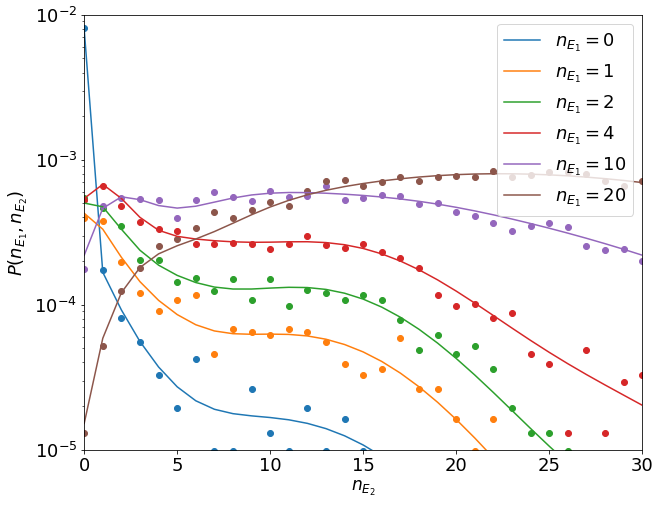

In [25]:
# plot probabilites from mock data and those computed by log_like 

k_max=200
k2=np.array(range(k_max))
k=np.array(range(31))
data = np.load("data.npy")

fig = plt.figure(figsize=(10,8))
num=20

plt.plot(k,props[0,:],label="$n_{E_1}=0$")
plt.scatter(k2,data[0])
plt.plot(k,props[1,:],label="$n_{E_1}=1$")
plt.scatter(k2,data[1])
plt.plot(k,props[2,:],label="$n_{E_1}=2$")
plt.scatter(k2,data[2])
plt.plot(k,props[4,:],label="$n_{E_1}=4$")
plt.scatter(k2,data[4])
plt.plot(k,props[10,:],label="$n_{E_1}=10$")
plt.scatter(k2,data[10])
plt.plot(k,props[20,:],label="$n_{E_1}=20$")
plt.scatter(k2,data[20])

plt.yscale('log')
plt.ylim([1e-5,1e-2])
plt.xlim([0,30])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel(r'$n_{E_2}$',fontsize=17)
plt.ylabel(r'$P(n_{E_1},n_{E_2})$',fontsize=18) #{\mathcal{L}}

plt.legend()
legend=plt.legend(fontsize=18)
plt.setp(legend.get_title(),fontsize=18)

plt.savefig("image.pdf", bbox_inches="tight")